# Extra lecture: more about Grover implementation

<center><img src="https://github.com/qiboteam/qiboedu/blob/main/figures/dall-e/merlion_detective.png?raw=true" alt="drawing" width="400"/></center>
<center><strong>Fig. 5:</strong> Merlion investigating Grover's details [DALL-E].</center>

### Introduction 

The aim of this lecture is to delve deeper into the Grover operators implementation.

In [1]:
# import numpy
import numpy as np

# import qibo and set backend
import qibo

# we collected all the grover scripts into scripts.grover
from qiboedu.scripts import plotscripts, utils, grover

qibo.set_backend("qibojit")

[Qibo 0.2.4|INFO|2024-02-27 15:47:53]: Using qibojit (numba) backend on /CPU:0


In [2]:
# set problem dimensionality
n = 5
# set the number of shots
nshots = 1000000
# generate the bitstrings list
bitstrings = utils.generate_bitstring_combinations(n)
# guilty index
guilty_index = 11
guilty_state = bitstrings[guilty_index]

<center><img src="https://github.com/qiboteam/qiboedu/blob/main/figures/grover_details.png?raw=true" alt="drawing" width="800"/></center>

In [3]:
print(bitstrings)
guilty_state = bitstrings[guilty_index]
print(f"\nGuilty state: {guilty_state}")

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']

Guilty state: 01011


### Grover until the first layer

In [4]:
# build the first layer
c = grover.build_initial_layer(n)
state = c().state()

print(c.draw())

q0: ─H───
q1: ─H───
q2: ─H───
q3: ─H───
q4: ─H───
q5: ─X─H─


In [5]:
mean = utils.compute_input_register_average_amplitude(state)
mean

0.17677669529663678

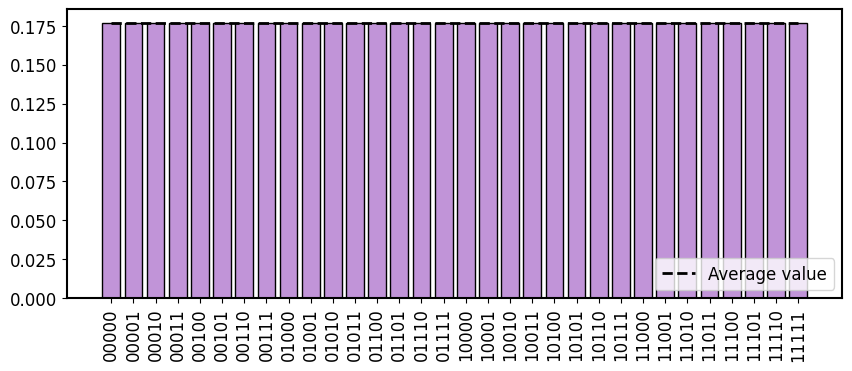

In [6]:
plotscripts.plot_input_register_amplitudes(
    state=c().state(), 
    save_as="step_0", 
    title="Initial layer",
    average_amp_value=mean
)

What about the amplitude if we also consider the ancilla?

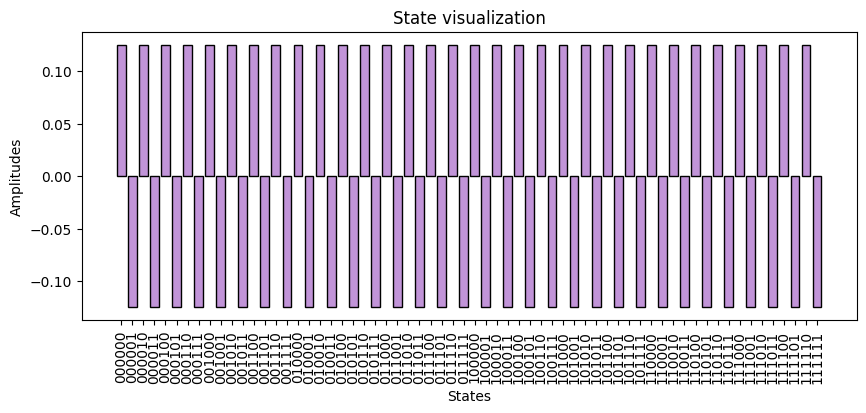

In [7]:
plotscripts.plot_amplitudes(c().state())

Since it was in the $|-\rangle$ st
ate, we have half of amplitudes multiplied by $-1$.

### Grover until the oracle

<center><img src="https://github.com/qiboteam/qiboedu/blob/main/figures/oracle_layers.png?raw=true" alt="drawing" width="800"/></center>

We can study what is happening to the system by setting an extra variable to the `build_oracle` function:

- setting `build_oracle(guilty_state, n, depth=1)` we build only the initial layer of NOT gates;
- setting `build_oracle(guilty_state, n, depth=2)` we build the NOT gates and the multi-controlled NOT;
- setting `build_oracle(guilty_state, n, depth=3)` we build the full oracle.

Setting `depth=None` (namely not setting `depth`) we get the same result of setting `depth=3`.

In [8]:
# initial layer with depth 1, 2, 3
c = grover.build_initial_layer(n) + grover.build_oracle(guilty_state, n, depth=3)
state = c().state()
mean_after_oracle = utils.compute_input_register_average_amplitude(state)

print(c.draw())

q0: ─H─X─o─X─
q1: ─H───o───
q2: ─H─X─o─X─
q3: ─H───o───
q4: ─H───o───
q5: ─X─H─X───


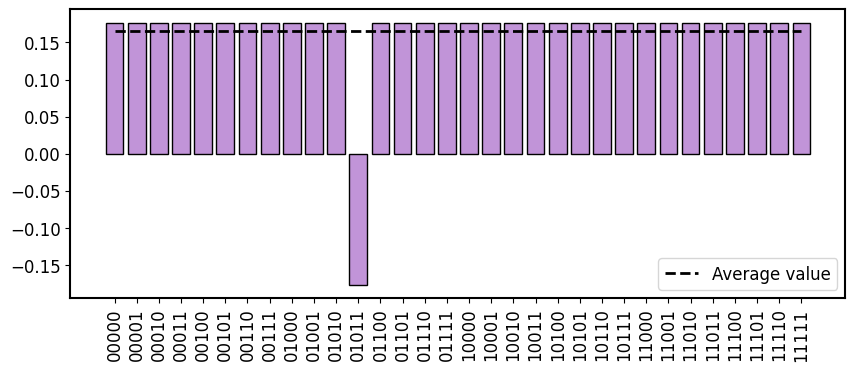

In [9]:
plotscripts.plot_input_register_amplitudes(
    state=c().state(), 
    save_as="step_3", 
    title="Full oracle applied",
    average_amp_value=mean_after_oracle
)

### Grover until the diffusion operator

<center><img src="https://github.com/qiboteam/qiboedu/blob/main/figures/diffusion_layers.png?raw=true" alt="drawing" width="800"/></center>

In [10]:
c = grover.build_initial_layer(n) + grover.build_oracle(guilty_state, n) + grover.build_diffusion_operator(n, depth=6)
state=c().state()

print(c.draw())

q0: ─H─X─o─X─H─X─o─X─H─
q1: ─H───o─H─X───o─X─H─
q2: ─H─X─o─X─H─X─o─X─H─
q3: ─H───o─H─X───o─X─H─
q4: ─H───o─H─X───o─X─H─
q5: ─X─H─X─X─────X─────


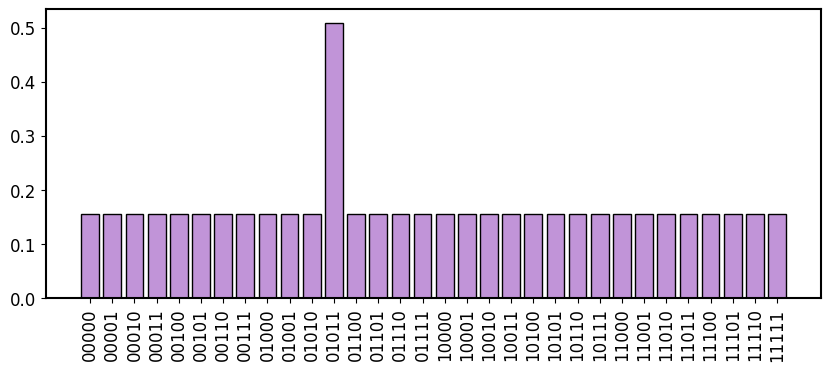

In [11]:
plotscripts.plot_input_register_amplitudes(
    state=state, 
    save_as="step_9", 
    title="H gates to the input register and back to superposition basis",
    #average_amp_value=mean_after_oracle
)

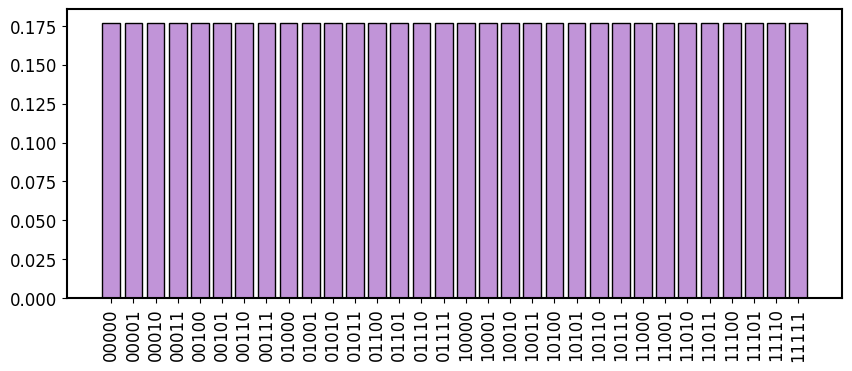

In [12]:
c = grover.build_initial_layer(n) 
state = c().state()

plotscripts.plot_input_register_amplitudes(
    state=state, 
    save_as="big_0", 
    title="H gates to the input register and back to superposition basis",
    #average_amp_value=mean_after_oracle
)

In [13]:
def exec_grover(n, guilty_state, ntimes=1, diff=True):
    c = grover.build_initial_layer(n)
    for i in range(ntimes):
        c += grover.build_oracle(guilty_state, n)
        if i != ntimes - 1:   
            c += grover.build_diffusion_operator(n)
        else:
            if diff is True:
                c+= grover.build_diffusion_operator(n)
    print(c.draw())
    return c().state()

q0: ─H─X─o─X─
q1: ─H───o───
q2: ─H─X─o─X─
q3: ─H───o───
q4: ─H───o───
q5: ─X─H─X───
q0: ─H─X─o─X─H─X─o─X─H─
q1: ─H───o─H─X───o─X─H─
q2: ─H─X─o─X─H─X─o─X─H─
q3: ─H───o─H─X───o─X─H─
q4: ─H───o─H─X───o─X─H─
q5: ─X─H─X─X─────X─────
q0: ─H─X─o─X─H─X─o─X─H─X─o─X─
q1: ─H───o─H─X───o─X─H───o───
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─
q3: ─H───o─H─X───o─X─H───o───
q4: ─H───o─H─X───o─X─H───o───
q5: ─X─H─X─X─────X───────X───
q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─
q1: ─H───o─H─X───o─X─H───o─H─X───o─X─H─
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─
q3: ─H───o─H─X───o─X─H───o─H─X───o─X─H─
q4: ─H───o─H─X───o─X─H───o─H─X───o─X─H─
q5: ─X─H─X─X─────X───────X─X─────X─────
q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─
q1: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o───
q2: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─
q3: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o───
q4: ─H───o─H─X───o─X─H───o─H─X───o─X─H───o───
q5: ─X─H─X─X─────X───────X─X─────X───────X───
q0: ─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─X─o─X─H─
q1: ─H───o─H─X───o─X

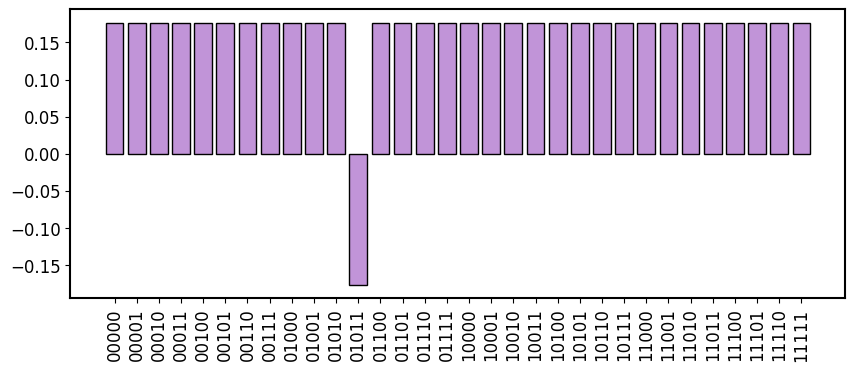

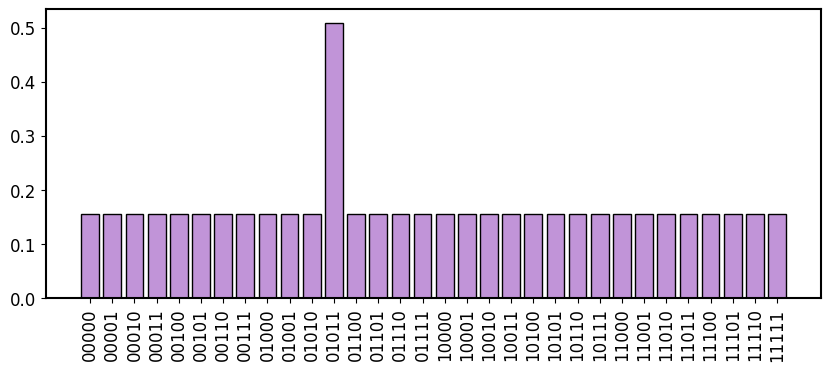

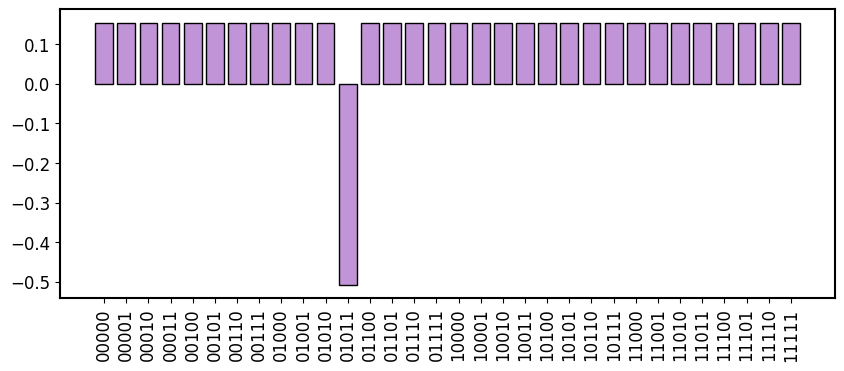

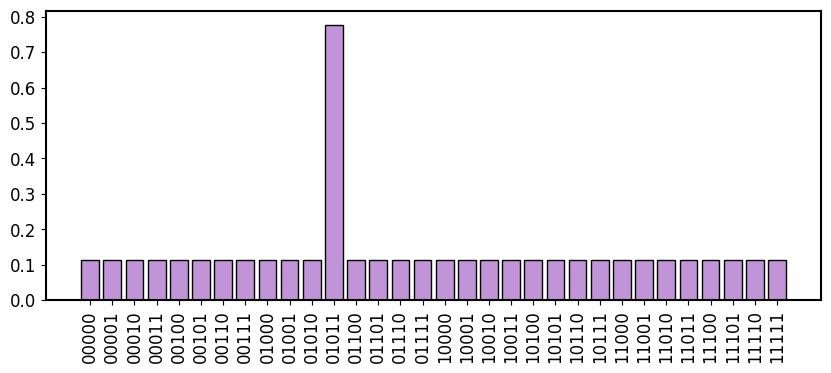

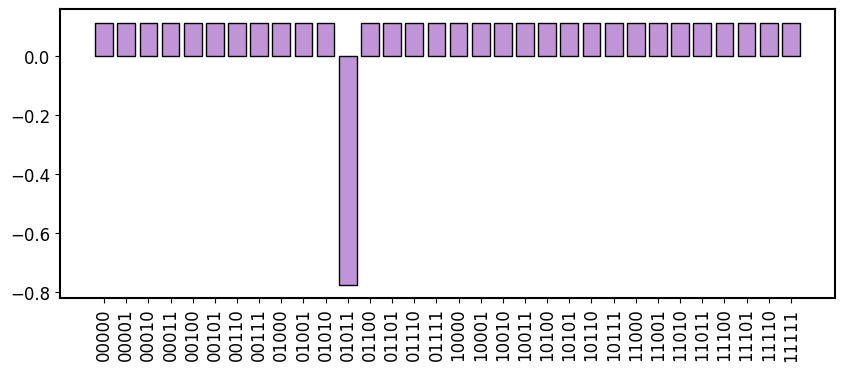

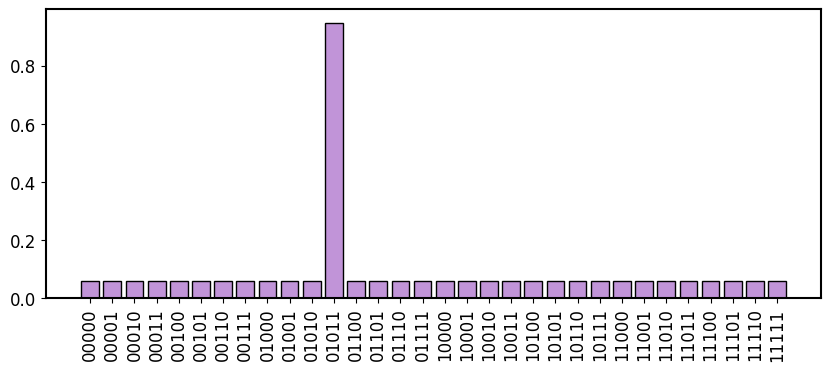

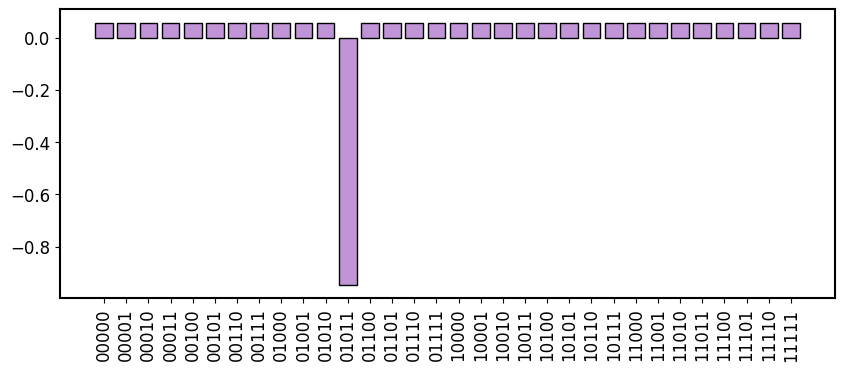

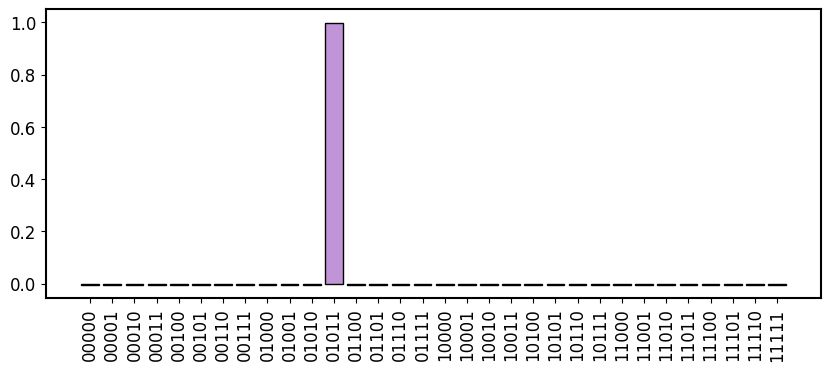

In [14]:
j = 1
for i in range(4):
    state = exec_grover(n, guilty_state, ntimes=i+1, diff=False)
    plotscripts.plot_input_register_amplitudes(state=state, save_as=f"big_{j}")
    state = exec_grover(n, guilty_state, ntimes=i+1, diff=True)
    plotscripts.plot_input_register_amplitudes(state=state, save_as=f"big_{j+1}")
    j += 2